## Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

## Useful functions

In [2]:
from scipy import stats
from typing import Tuple


def save_df(df: pd.DataFrame, name: str, directory: str, message=None) -> None:
    """
    Function for saving DataFrame to .csv file in the given directory with given name

        Args:
            df (pd.DataFrame): DataFrame to be saved
            name (str): Name of file
            directory (str): Name of the directory where the file is being saved
            message (str): Message to be printed

        Returns:
            None
    """
    df.to_csv(directory + "/" + name, encoding="utf-8")
    if message is None:
        print(f"{name} saved in {directory}/")
    else:
        print(message)


def calculate_SPI(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to calculate Standardized Precipitation Index (SPI) for the given DataFrame.
    The function fits a gamma distribution to the precipitation data and then transforms the
    cumulative distribution function (CDF) of the gamma distribution to calculate the SPI values.
    The returned DataFrame has the same index as the input DataFrame, with each date associated
    with its corresponding SPI value.

    Args:
    df (pd.DataFrame): DataFrame containing the '24h_precipitation_mm' column with precipitation data.

    Returns:
    pd.DataFrame: DataFrame containing SPI for the given data.
    """
    precip_sum = df["24h_precipitation_mm"]
    precip_sum[precip_sum <= 0] = 1e-15  # !!!!!!!!!
    params = stats.gamma.fit(precip_sum, floc=0)
    shape, loc, scale = params
    cdf = stats.gamma.cdf(precip_sum, shape, loc, scale)
    SPI = stats.norm.ppf(cdf)
    return pd.DataFrame({"SPI": SPI}, index=df.index)


def get_SPI(
    df: pd.DataFrame, voi: str, save=True
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Function to calculate SPI for different periods (SPI-1, SPI-3, SPI-12) and save them to CSV files.

    Args:
    df (pd.DataFrame): DataFrame containing the '24h_precipitation_mm' column with precipitation data.
    voi (str): Name of the analyzed voivodeship.
    save (bool): Flags whether to save the SPI results.

    Returns:
    tuple: Tuple containing SPI-1, SPI-3, and SPI-12 as DataFrames.
    """

    print("Calculating SPI...")

    df.index = pd.to_datetime(df.index)

    SPI_1Y = df.resample("YE").agg({"24h_precipitation_mm": "sum"}).dropna()
    SPI_1 = calculate_SPI(SPI_1Y)

    SPI_3M = df.resample("QE").agg({"24h_precipitation_mm": "sum"}).dropna()
    SPI_3 = calculate_SPI(SPI_3M)

    SPI_1M = df.resample("ME").agg({"24h_precipitation_mm": "sum"}).dropna()
    SPI_12 = calculate_SPI(SPI_1M)

    if save:
        save_df(SPI_1, f"{voi}_SPI_yearly.csv", "../results")
        save_df(SPI_3, f"{voi}_SPI_quarterly.csv", "../results")
        save_df(SPI_12, f"{voi}_SPI_monthly.csv", "../results")

    print("SPI calculated.")

    return SPI_1, SPI_3, SPI_12

In [3]:
import geopandas as gpd


def clip_precip_to_voi(precip: pd.DataFrame, voi_gdf: gpd.GeoDataFrame) -> pd.DataFrame:
    """Function to clip precipitation data to only one voivodeship

    Args:
        precip (pd.DataFrame): Data containing precipitation over years
        voi_gdf (gpd.GeoDataFrame): GeoDataFrame containing details about stations from given voivodeship

    Returns:
        pd.DataFrame: DataFrame containing precipitation data merged with stations'
                      detail from one voivodeship
    """

    merged_df = precip.merge(
        voi_gdf, how="inner", left_on="station_code", right_on="ID"
    )
    merged_df = merged_df[
        [
            "station_code",
            "station_name",
            "year",
            "month",
            "day",
            "24h_precipitation_mm",
            "SMDB_status",
            "precip_type",
            "snow_cover_cm",
            "river",
            "lat",
            "lon",
            "altitude",
        ]
    ]

    return merged_df


def clip_to_voivodeship(
    gdf: gpd.GeoDataFrame, geojson: gpd.GeoDataFrame, voi: str
) -> Tuple[gpd.GeoSeries, gpd.GeoDataFrame]:
    """Function to clip GeoDataFrame to specific voivodeship borders

    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame containing stations data
        geojson (gpd.GeoDataFrame): GeoDataFrame containing voivodeship borders
        voi (str): Name of the voivodeship to clip the data to

    Returns:
        Tuple[gpd.GeoSeries, gpd.GeoDataFrame]: Tuple containing voivodeship polygon
                                                and clipped GeoDataFrame
    """
    voi_polygon = geojson[geojson["name"] == voi]["geometry"]
    voi_gdf = gdf[gdf.within(voi_polygon.geometry.iloc[0])]
    return voi_polygon, voi_gdf


def get_voivodeship_borders() -> gpd.GeoDataFrame:
    """Function to fetch and return voivodeship borders data as GeoDataFrame from
       a specified URL with spaces and dashes removed from voivodeship names.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame containing voivodeship borders
    """
    geojson = gpd.read_file(
        "https://simplemaps.com/static/svg/country/pl/admin1/pl.json"
    )
    geojson["name"] = (
        geojson["name"]
        .apply(lambda x: x.replace(" ", ""))
        .apply(lambda x: x.replace("-", ""))
    )
    return geojson


def clip_data_to_voi(stations: gpd.GeoDataFrame, voi: str) -> gpd.GeoDataFrame:
    """Pipeline for clipping all the data to voivodeships

    Args:
        precip (pd.DataFrame): All precipitation data
        stations (gpd.GeoDataFrame): All stations data
        voi (str): Voivodeship name

    Returns:
        list[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]: Polygon of voivodeship, precipitation data clipped
          to voivodeship & stations clipped to voivodeship
    """
    print(f"Clipping precipitation and stations data to {voi} voivodeship...")
    geojson = get_voivodeship_borders()
    voi_polygon, voi_stations_gdf = clip_to_voivodeship(stations, geojson, voi)
    # voi_precip_gdf = clip_precip_to_voi(precip, voi_stations_gdf)

    print("Clipping ended")

    return voi_polygon  # , voi_precip_gdf#, voi_stations_gdf

## Loading data

In [4]:
preprocessed_voi_df = pd.read_csv(
    "../data/preprocessed_Lubusz_data.csv", index_col="date"
)
preprocessed_voi_df

,station_code,station_name,24h_precipitation_mm,SMDB_status,precip_type,snow_cover_cm,river,lat,lon,altitude
date,,,,,,,,,,
1991-01-01,251150110,ŻAGAŃ,1.9,Normal,Water,0.0,Bóbr,51.649722,15.293611,96.0
1991-01-02,251150110,ŻAGAŃ,2.5,Normal,Water,0.0,Bóbr,51.649722,15.293611,96.0
1991-01-03,251150110,ŻAGAŃ,1.1,Normal,Water,0.0,Bóbr,51.649722,15.293611,96.0
1991-01-04,251150110,ŻAGAŃ,3.2,Normal,Water,0.0,Bóbr,51.649722,15.293611,96.0
1991-01-05,251150110,ŻAGAŃ,1.3,Normal,Water,0.0,Bóbr,51.649722,15.293611,96.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-24,252150180,LUBINICKO-ŚWIEBODZIN,2.5,Normal,Water,0.0,Obrzyca,52.242778,15.545278,88.0
2022-12-25,252150180,LUBINICKO-ŚWIEBODZIN,8.6,Normal,Water,0.0,Obrzyca,52.242778,15.545278,88.0
2022-12-26,252150180,LUBINICKO-ŚWIEBODZIN,0.5,Normal,Water,0.0,Obrzyca,52.242778,15.545278,88.0


In [5]:
stations_gdf = gpd.read_file("../data/stations.shp", encoding="cp1250")
voi_polygon = clip_data_to_voi(stations_gdf, "Lubusz")
voi_polygon

Clipping precipitation and stations data to Lubusz voivodeship...
Clipping ended


7    POLYGON ((16.37113 51.74919, 16.32214 51.69995...
Name: geometry, dtype: geometry

## SPIs analysis for an each station from voivodeship (Lubusz)

In [6]:
def get_stations_SPI_statistics(SPI_1, SPI_3, SPI_12, station_name, voi):
    save_df(
        pd.concat(

            [

                SPI_1.describe().rename(columns={"SPI": "Values"}),

                SPI_3.describe().rename(columns={"SPI": "Values"}),

                SPI_12.describe().rename(columns={"SPI": "Values"}),

            ],

            axis=1,

            keys=["SPI_1", "SPI_3", "SPI_12"],
        ),

        f"{station_name}-{voi}_SPI_statistics.csv",

        "../results",
    )

    print(

        f"Saved SPIs descriptive statistics from {station_name} station in the {voi} voivodeship in results/{station_name}-{voi}_SPI_statistics.csv"
    )

In [7]:
def map_to_range(value):
    SPI_ranges = {
        "Extremely wet": (2.0, float("inf")),
        "Very wet": (1.5, 1.99),
        "Moderately wet": (1.0, 1.49),
        "Moderate conditions": (-0.99, 0.99),
        "Moderate drought": (-1.49, -1.0),
        "Severe drought": (-1.99, -1.5),
        "Extreme drought": (-float("inf"), -2.0),
    }
    for range_name, (lower_bound, upper_bound) in SPI_ranges.items():
        if lower_bound <= value <= upper_bound:
            return f"{range_name}"

In [8]:
def visualize_stations_SPI(SPI_1, SPI_3, SPI_12, s, voi):
    SPI_1["State"] = SPI_1["SPI"].map(map_to_range)
    SPI_3["State"] = SPI_3["SPI"].map(map_to_range)
    SPI_12["State"] = SPI_12["SPI"].map(map_to_range)

    SPI_dict = {"SPI_1": SPI_1, "SPI_3": SPI_3, "SPI_12": SPI_12}

    color_palette = {
        "Extremely wet": "darkblue",
        "Very wet": "blue",
        "Moderately wet": "cornflowerblue",
        "Moderate conditions": "mediumaquamarine",
        "Moderate drought": "wheat",
        "Severe drought": "sandybrown",
        "Extreme drought": "firebrick",
    }

    hue_order = [
        "Extremely wet",
        "Very wet",
        "Moderately wet",
        "Moderate conditions",
        "Moderate drought",
        "Severe drought",
        "Extreme drought",
    ]

    for spi_key, spi_val in SPI_dict.items():
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        sns.lineplot(
            spi_val, x=spi_val.index, y="SPI", color="darkgrey", alpha=0.7, ax=ax
        )

        sns.scatterplot(
            spi_val,
            x=spi_val.index,
            y="SPI",
            hue="State",
            ax=ax,
            palette=color_palette,
            hue_order=hue_order,
        )
        ax.legend(
            title="Precipitation conditions",
            loc="right",
            bbox_to_anchor=(0.77, 0.25, 0.5, 0.5),
        )
        ax.set(
            title=f"{spi_key} over time for station {s} in {voi} voivodeship",
            xlabel="Date",
            ylabel="SPI",
        )
        ax.grid(True)
        plt.savefig(f"../results/{spi_key}_{s}-{voi}.png", bbox_inches="tight")
        print(
            f"Figure with {spi_key} for station {s} in {voi} voivodeship saved in results/{spi_key}_{s}-{voi}.png"
        )
        # plt.show()

In [9]:
def compare_stations_SPI(SPI_1, SPI_3, SPI_12, s, voi):
    SPI_1_resampled = SPI_1.resample("YE").agg({"SPI": "mean"})
    SPI_3_resampled = SPI_3.resample("YE").agg({"SPI": "mean"})

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    sns.lineplot(
        SPI_1_resampled,
        x=SPI_1_resampled.index,
        y=SPI_1_resampled["SPI"],
        ax=ax,
        label="SPI_1",
        alpha=0.5,
    )
    sns.lineplot(
        SPI_3_resampled,
        x=SPI_3_resampled.index,
        y=SPI_3_resampled["SPI"],
        ax=ax,
        label="SPI_3",
        alpha=0.5,
    )
    sns.lineplot(
        SPI_12, x=SPI_12.index, y=SPI_12["SPI"], ax=ax, label="SPI_12", alpha=0.5
    )

    ax.set(
        title=f"Comparison of SPIs for station {s} in {voi} voivodeship", xlabel="Year"
    )
    ax.grid(True)

    plt.savefig(f"../results/SPI_comparison_{s}-{voi}.png", bbox_inches="tight")
    print(
        f"Figure with SPIs comparison for station {s} in {voi} voivodeship saved in results/SPI_comparison_{s}-{voi}.png"
    )
    # plt.show()

In [10]:
def plot_spi_points(gdf, ax, column, title, voi_polygon):
    color_palette = {
        "Extremely wet": "darkblue",
        "Very wet": "blue",
        "Moderately wet": "cornflowerblue",
        "Moderate conditions": "mediumaquamarine",
        "Moderate drought": "wheat",
        "Severe drought": "sandybrown",
        "Extreme drought": "firebrick",
    }

    x, y = voi_polygon.iloc[0].exterior.xy
    ax.plot(x, y, color="blue")
    ax.set_xlim([min(gdf.geometry.x) - 0.75, max(gdf.geometry.x) + 0.75])
    ax.set_ylim([min(gdf.geometry.y) - 0.75, max(gdf.geometry.y) + 0.75])
    sns.scatterplot(
        gdf,
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        hue=column,
        ax=ax,
        palette=color_palette,
    )
    ax.set(title=title, xlabel="Longitude", ylabel="Latitude")
    ax.legend(title="Precipitation conditions")


def voi_SPI_map(avg_SPIs, voi_polygon, voi):
    gdf = gpd.GeoDataFrame(
        avg_SPIs,
        geometry=[
            Point(lon, lat) for lon, lat in zip(avg_SPIs["lon"], avg_SPIs["lat"])
        ],
        crs="EPSG:4326",
    )

    gdf["SPI_1_State"] = gdf["SPI_1"].map(map_to_range)
    gdf["SPI_3_State"] = gdf["SPI_3"].map(map_to_range)
    gdf["SPI_12_State"] = gdf["SPI_12"].map(map_to_range)

    fig, ax = plt.subplots(3, 1, figsize=(6, 25))

    titles = [f"Mean SPI_{i} in {voi} over time" for i in [1, 3, 12]]
    columns = ["SPI_1_State", "SPI_3_State", "SPI_12_State"]

    for i, (column, title) in enumerate(zip(columns, titles)):
        plot_spi_points(gdf, ax[i], column, title, voi_polygon)

    plt.suptitle(f"Mean SPIs over time in the {voi} voivodeship", fontsize=16, y=1)
    plt.tight_layout()
    plt.savefig(f"../results/{voi}_SPI_map.png", bbox_inches="tight")
    print(
        f"Figure with map of SPIs in the {voi} voivodeship saved in results/{voi}_SPI_map.png"
    )
    # plt.show()

In [11]:
def stations_SPI_pipeline(preprocessed_voi_df, voi_polygon, voi):
    station_names = preprocessed_voi_df["station_name"].unique()
    avg_SPIs = pd.DataFrame(
        index=station_names, columns=["SPI_1", "SPI_3", "SPI_12", "lat", "lon"]
    )
    for s in station_names:
        SPI_1, SPI_3, SPI_12 = get_SPI(
            preprocessed_voi_df[preprocessed_voi_df["station_name"] == s],
            voi,
            False,
        )
        avg_SPIs.loc[s, "SPI_1"] = SPI_1["SPI"].mean()
        avg_SPIs.loc[s, "SPI_3"] = SPI_3["SPI"].mean()
        avg_SPIs.loc[s, "SPI_12"] = SPI_12["SPI"].mean()
        avg_SPIs.loc[s, "lat"] = preprocessed_voi_df[
            preprocessed_voi_df["station_name"] == s
        ]["lat"].iloc[0]
        avg_SPIs.loc[s, "lon"] = preprocessed_voi_df[
            preprocessed_voi_df["station_name"] == s
        ]["lon"].iloc[0]
        SPI_1["SPI"] = SPI_1["SPI"].round(2)
        SPI_3["SPI"] = SPI_3["SPI"].round(2)
        SPI_12["SPI"] = SPI_12["SPI"].round(2)
        get_stations_SPI_statistics(SPI_1, SPI_3, SPI_12, s, voi)
        visualize_stations_SPI(SPI_1, SPI_3, SPI_12, s, voi)
        compare_stations_SPI(SPI_1, SPI_3, SPI_12, s, voi)
    voi_SPI_map(avg_SPIs, voi_polygon, voi)

Calculating SPI...
SPI calculated.
ŻAGAŃ-Lubusz_SPI_statistics.csv saved in ../results/
Saved SPIs descriptive statistics from ŻAGAŃ station in the Lubusz voivodeship in results/ŻAGAŃ-Lubusz_SPI_statistics.csv
Figure with SPI_1 for station ŻAGAŃ in Lubusz voivodeship saved in results/SPI_1_ŻAGAŃ-Lubusz.png
Figure with SPI_3 for station ŻAGAŃ in Lubusz voivodeship saved in results/SPI_3_ŻAGAŃ-Lubusz.png
Figure with SPI_12 for station ŻAGAŃ in Lubusz voivodeship saved in results/SPI_12_ŻAGAŃ-Lubusz.png
Figure with SPIs comparison for station ŻAGAŃ in Lubusz voivodeship saved in results/SPI_comparison_ŻAGAŃ-Lubusz.png
Calculating SPI...
SPI calculated.
BOCZÓW-Lubusz_SPI_statistics.csv saved in ../results/
Saved SPIs descriptive statistics from BOCZÓW station in the Lubusz voivodeship in results/BOCZÓW-Lubusz_SPI_statistics.csv
Figure with SPI_1 for station BOCZÓW in Lubusz voivodeship saved in results/SPI_1_BOCZÓW-Lubusz.png
Figure with SPI_3 for station BOCZÓW in Lubusz voivodeship saved

C:\Users\adamp\AppData\Local\Temp\ipykernel_22008\4111403962.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))


Figure with SPI_1 for station KRZYŻ in Lubusz voivodeship saved in results/SPI_1_KRZYŻ-Lubusz.png
Figure with SPI_3 for station KRZYŻ in Lubusz voivodeship saved in results/SPI_3_KRZYŻ-Lubusz.png
Figure with SPI_12 for station KRZYŻ in Lubusz voivodeship saved in results/SPI_12_KRZYŻ-Lubusz.png
Figure with SPIs comparison for station KRZYŻ in Lubusz voivodeship saved in results/SPI_comparison_KRZYŻ-Lubusz.png
Calculating SPI...
SPI calculated.
SANICE-Lubusz_SPI_statistics.csv saved in ../results/
Saved SPIs descriptive statistics from SANICE station in the Lubusz voivodeship in results/SANICE-Lubusz_SPI_statistics.csv
Figure with SPI_1 for station SANICE in Lubusz voivodeship saved in results/SPI_1_SANICE-Lubusz.png
Figure with SPI_3 for station SANICE in Lubusz voivodeship saved in results/SPI_3_SANICE-Lubusz.png
Figure with SPI_12 for station SANICE in Lubusz voivodeship saved in results/SPI_12_SANICE-Lubusz.png
Figure with SPIs comparison for station SANICE in Lubusz voivodeship sav

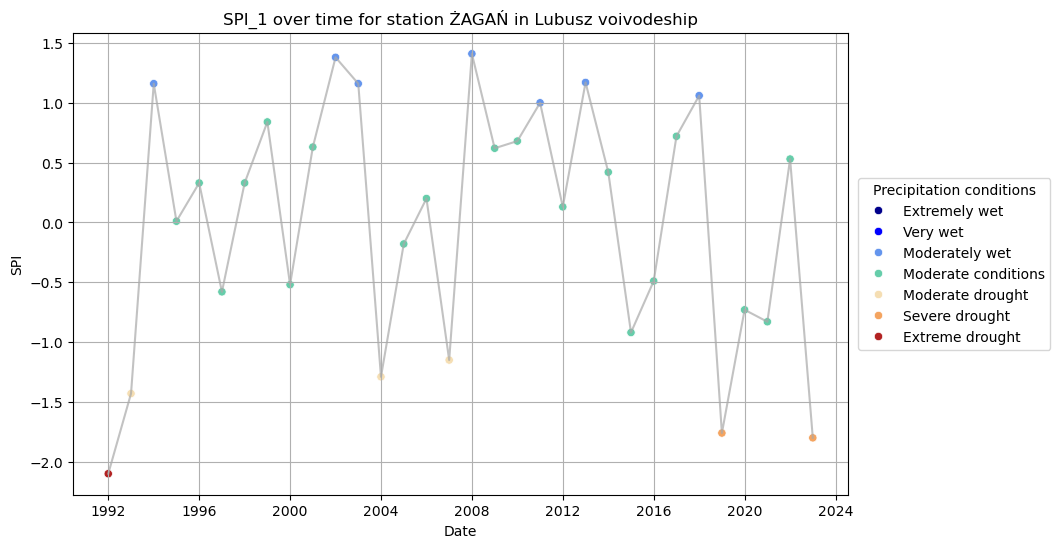

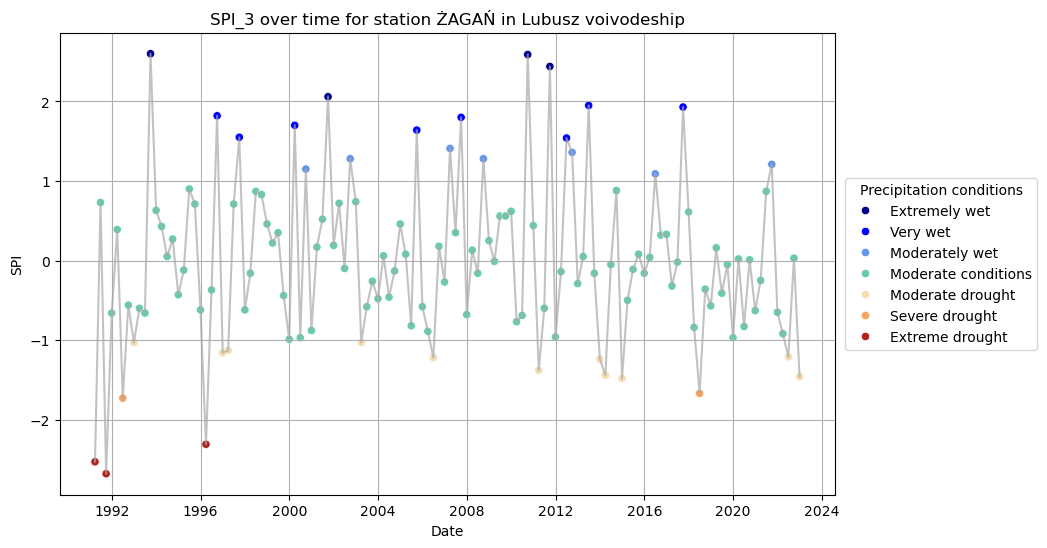

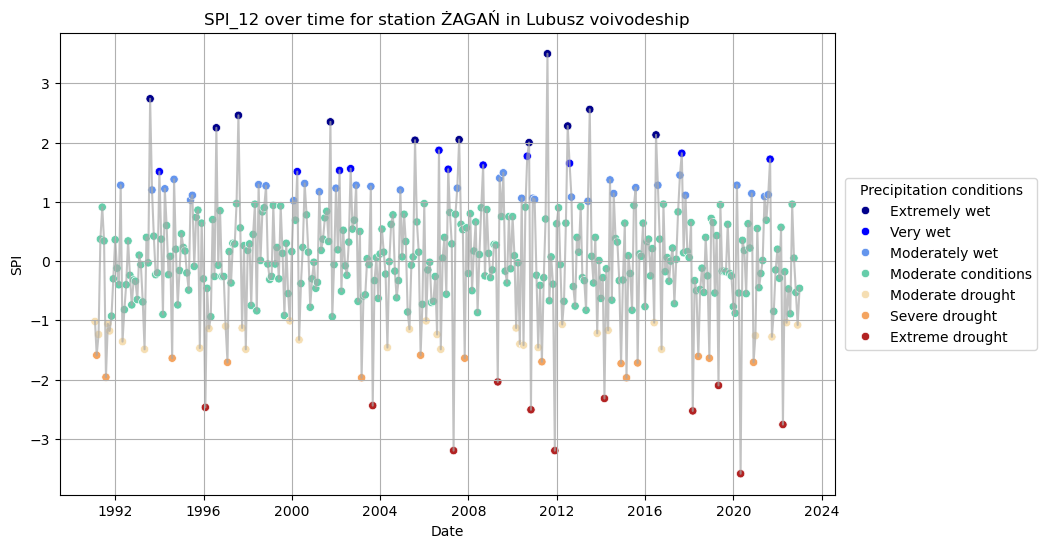

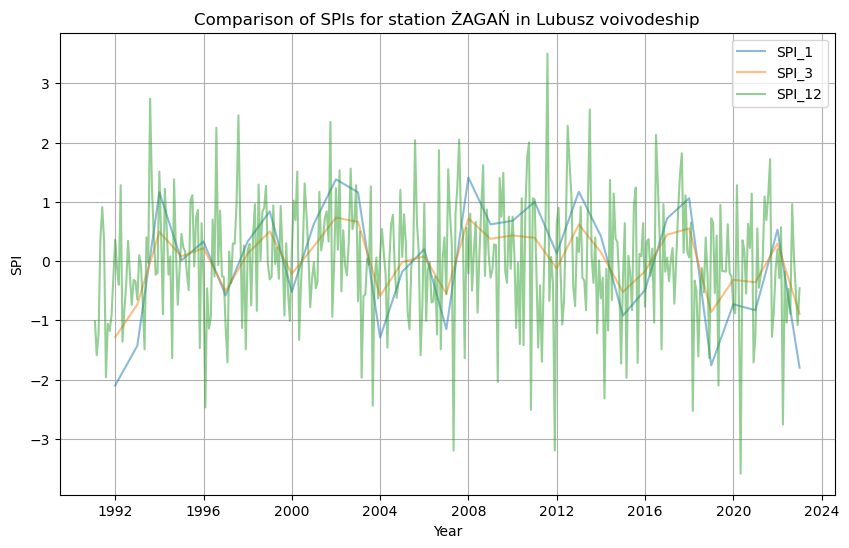

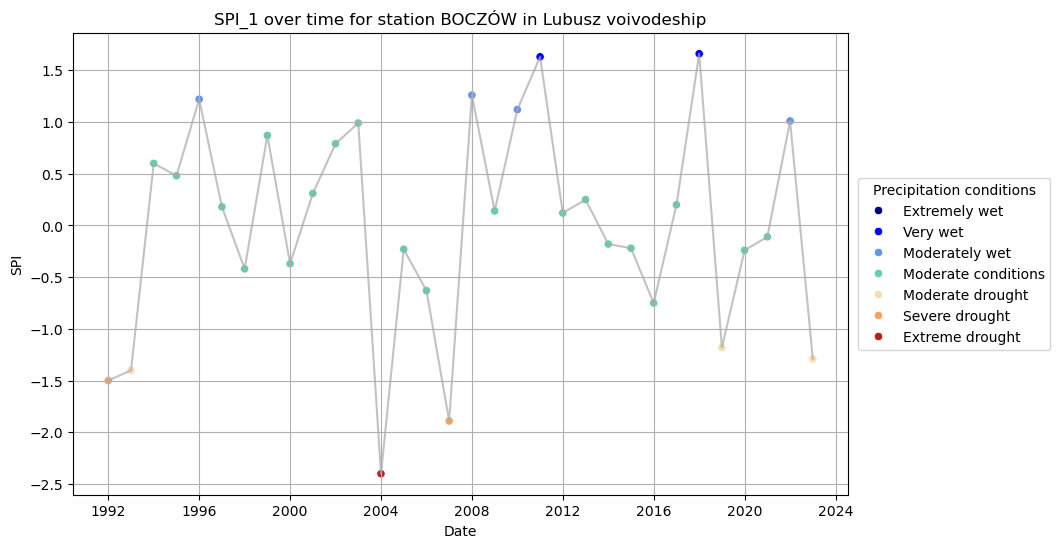

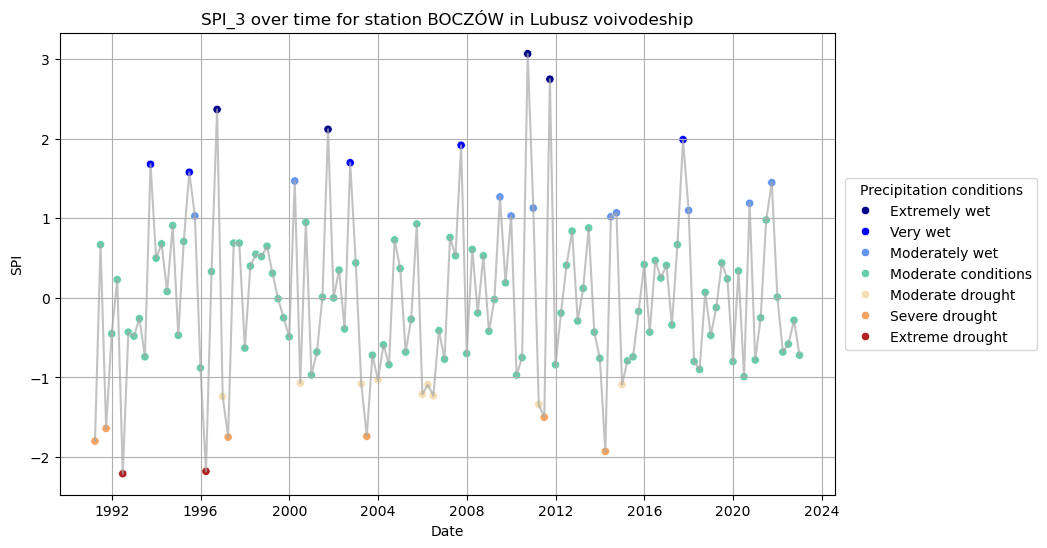

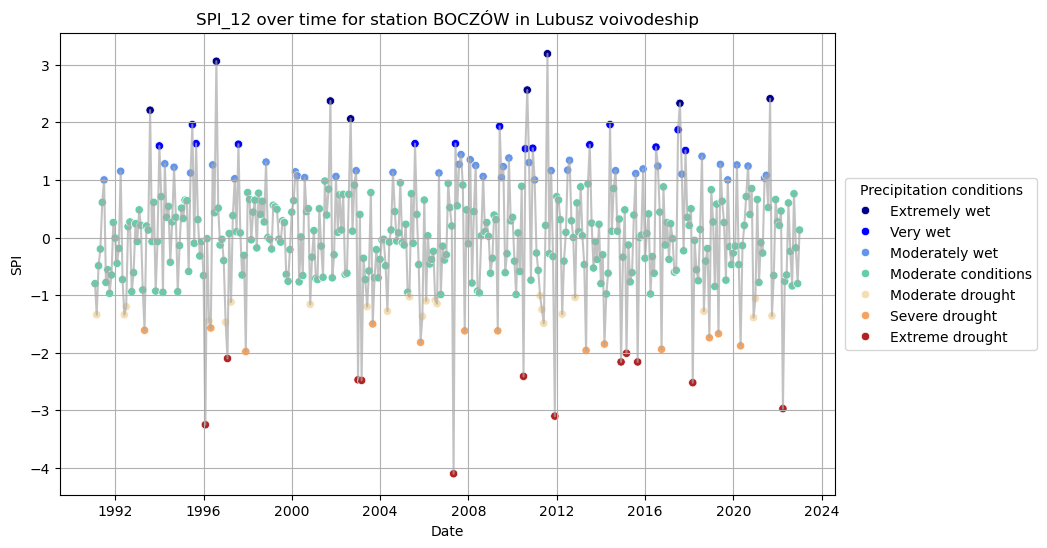

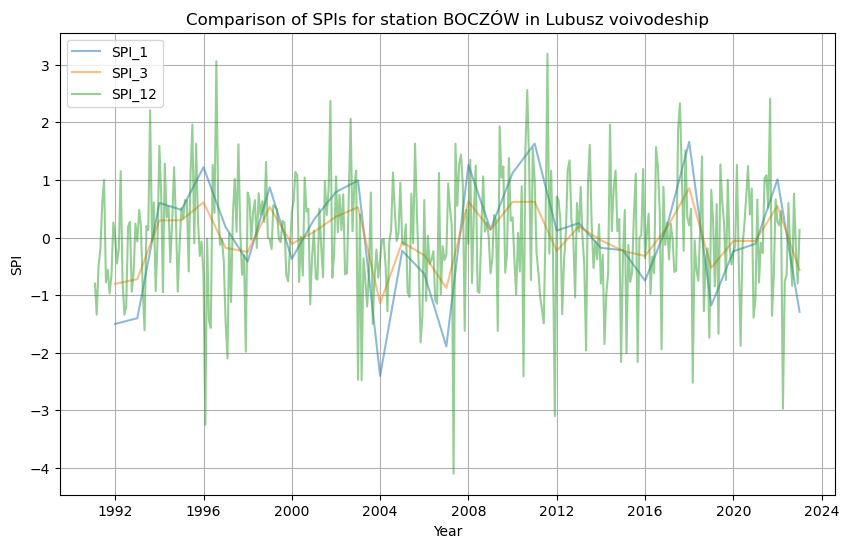

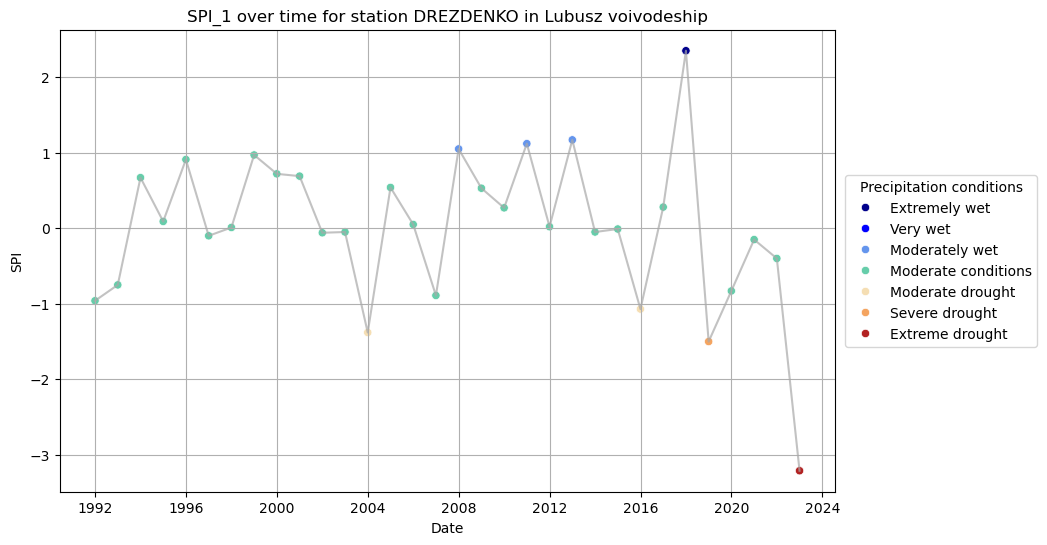

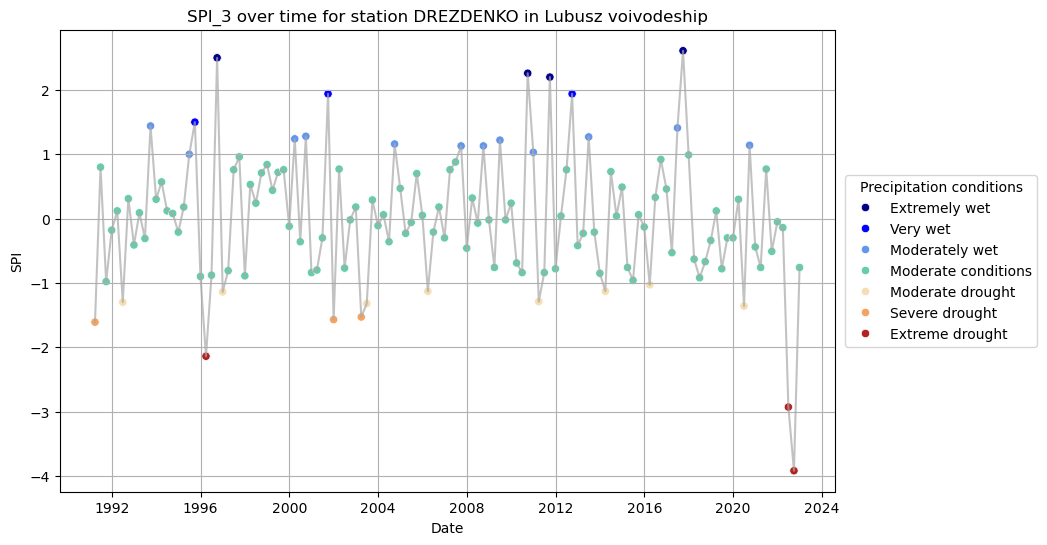

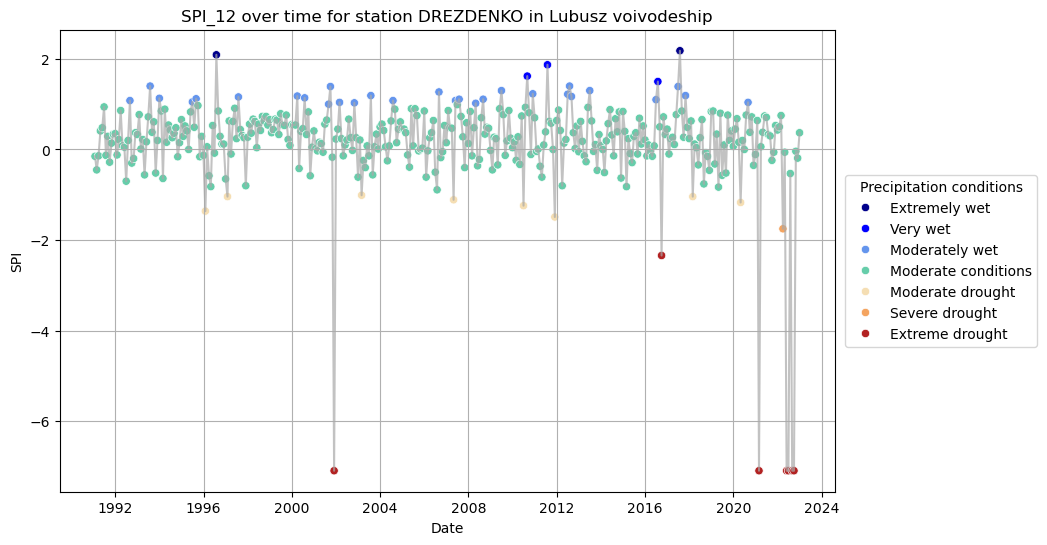

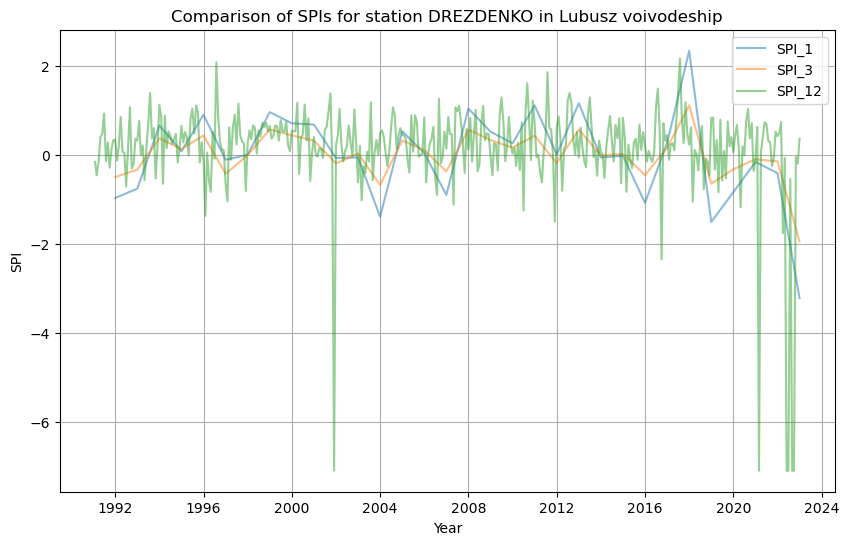

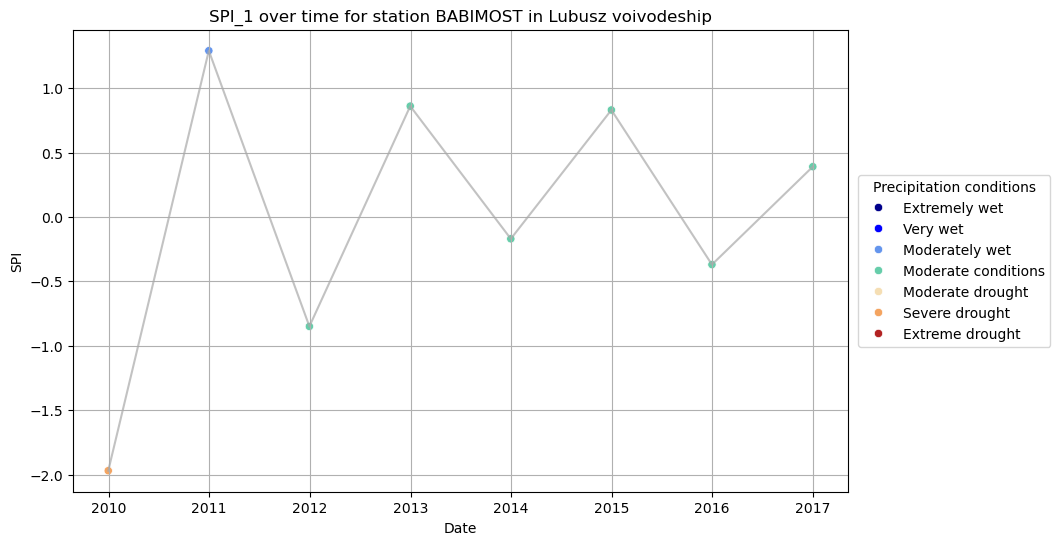

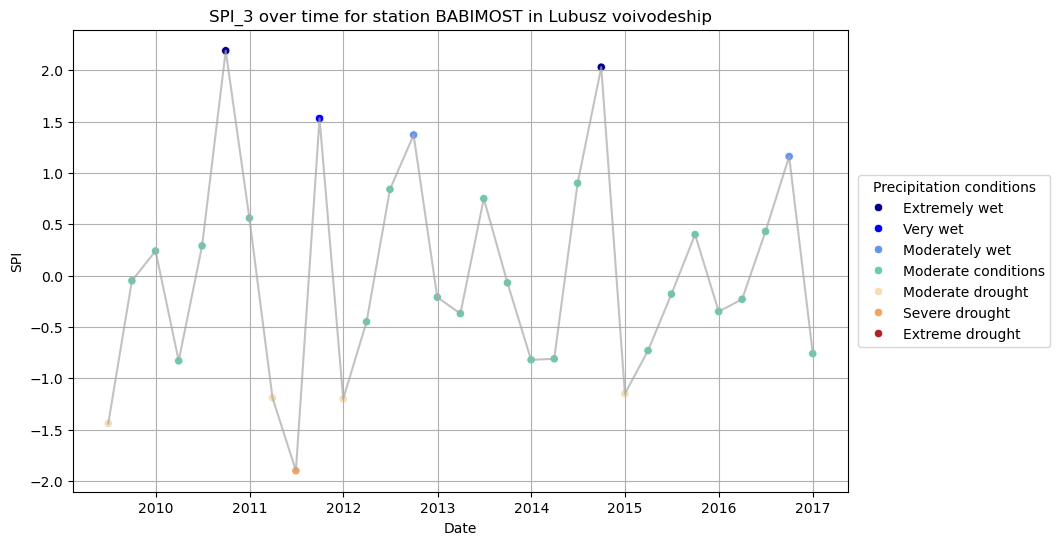

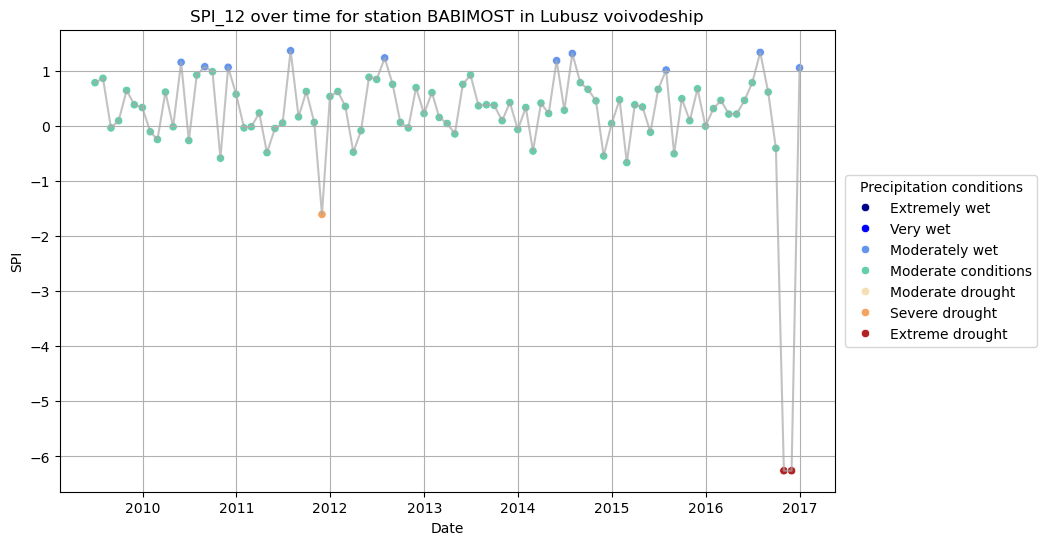

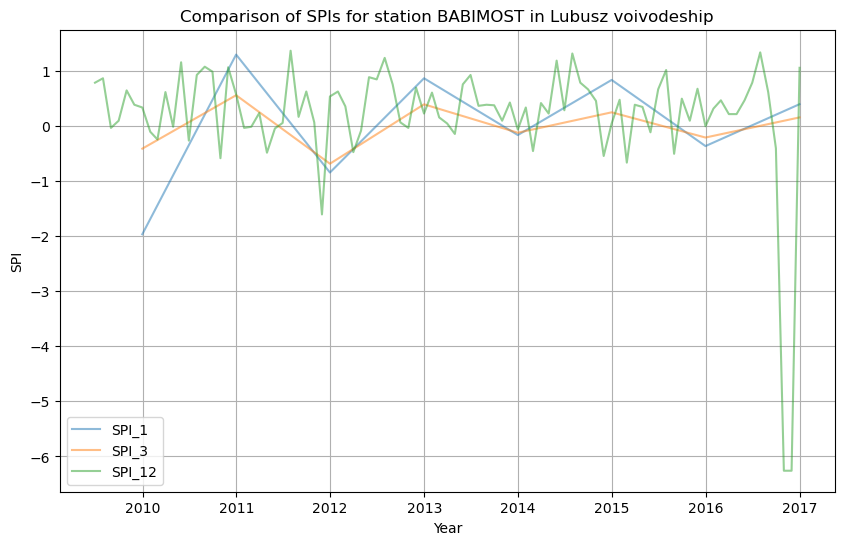

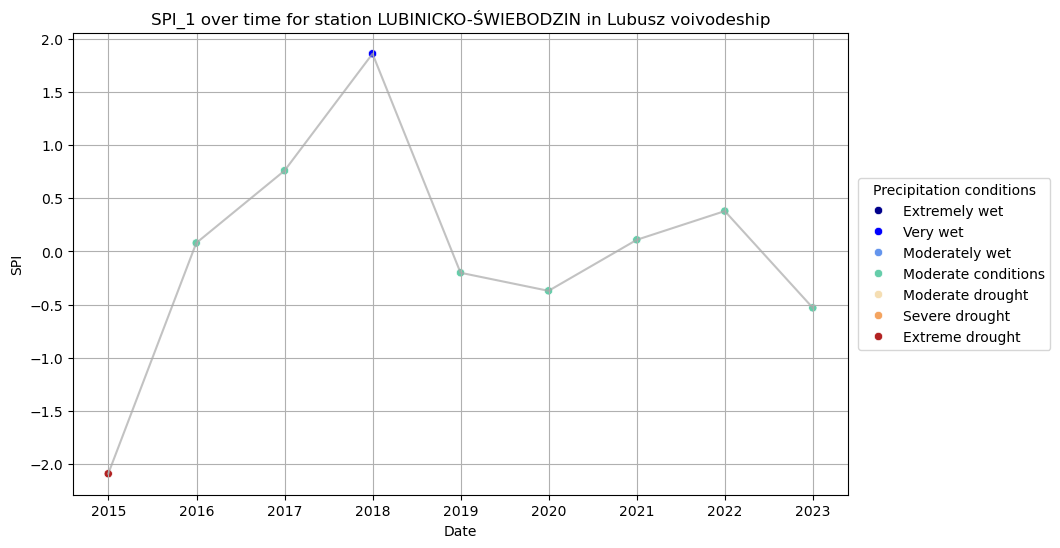

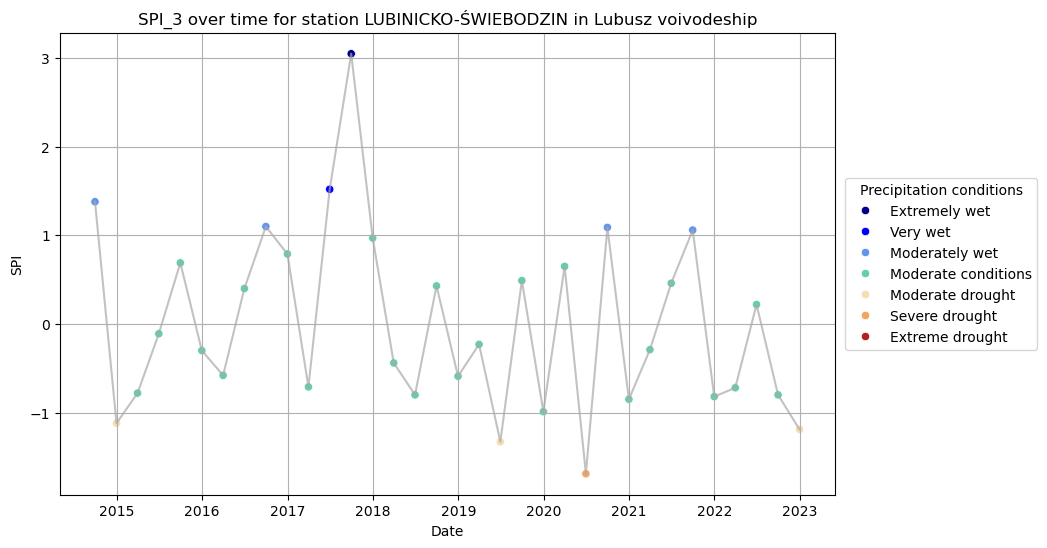

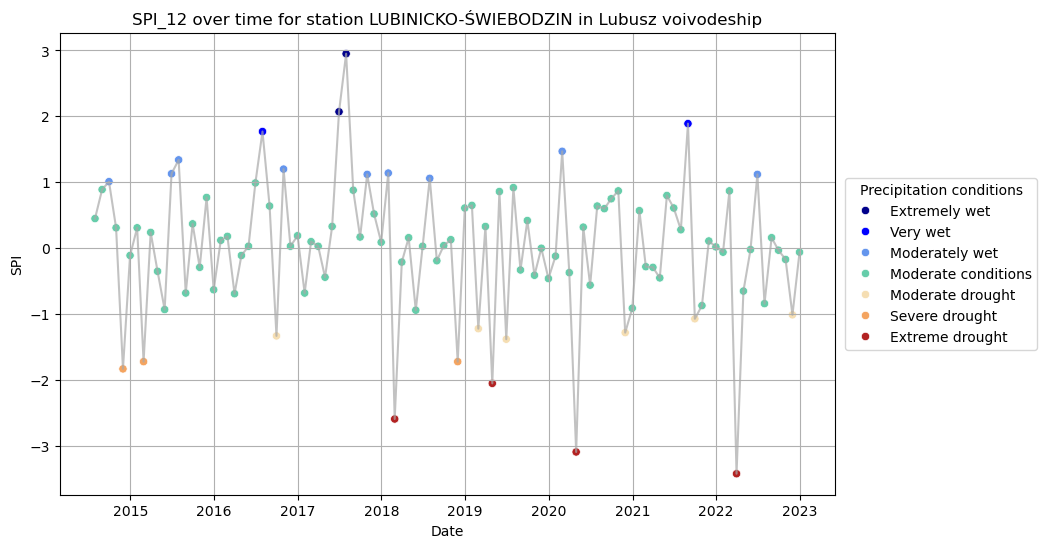

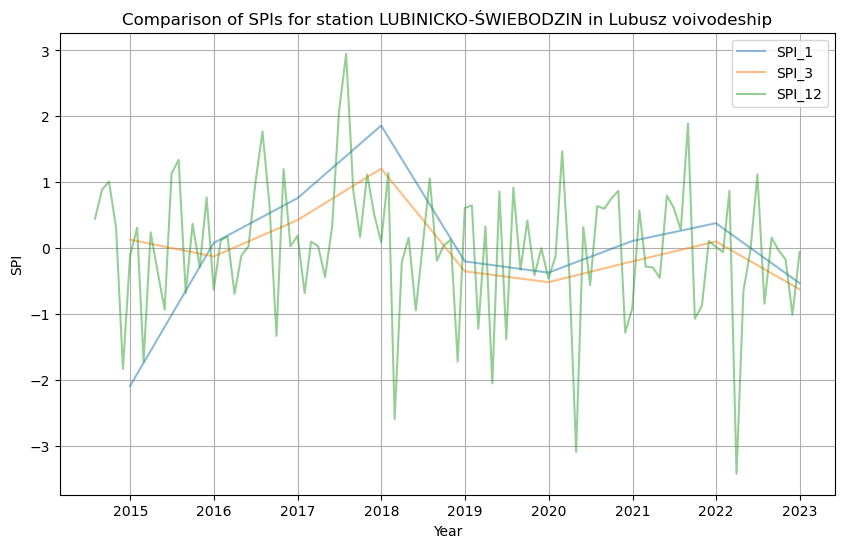

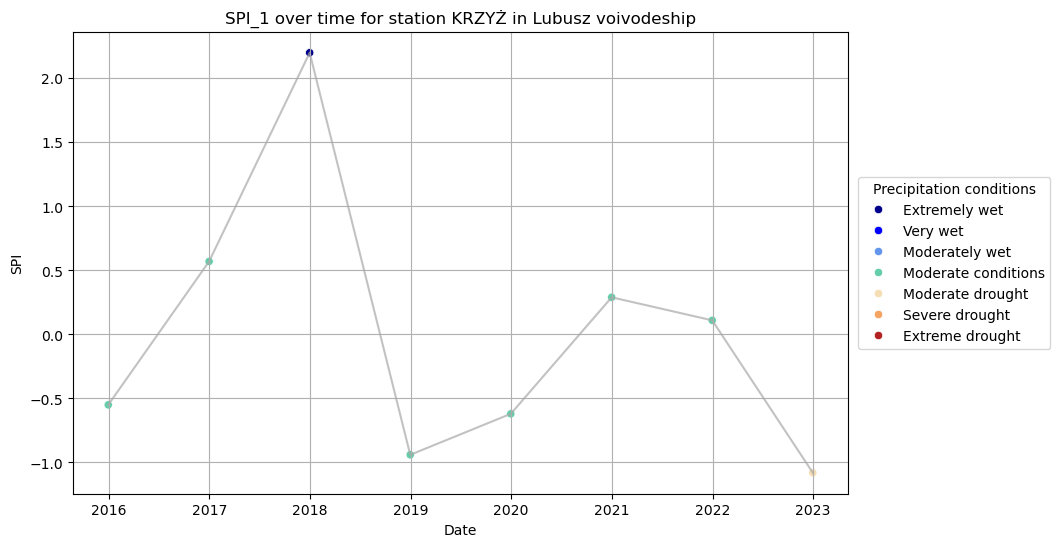

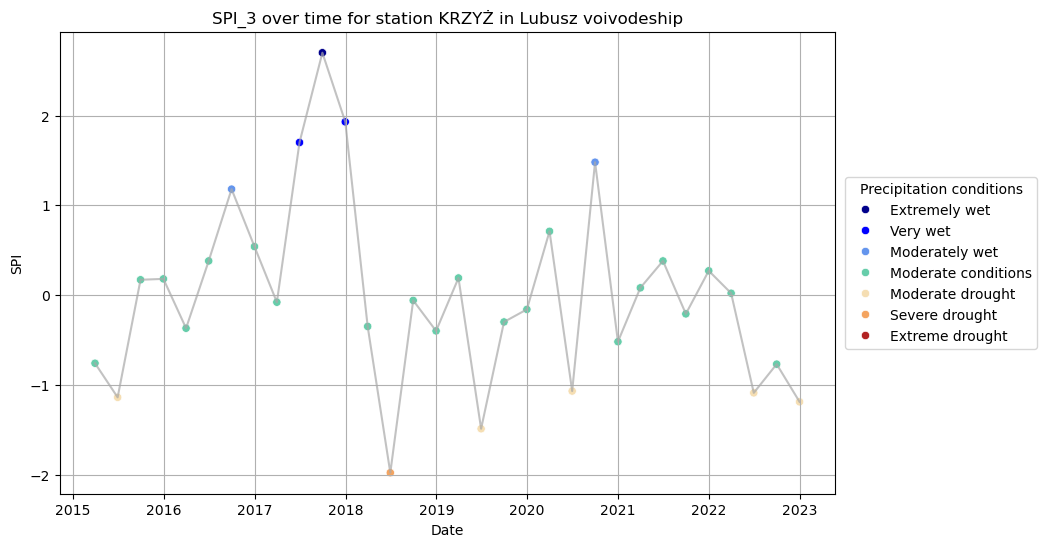

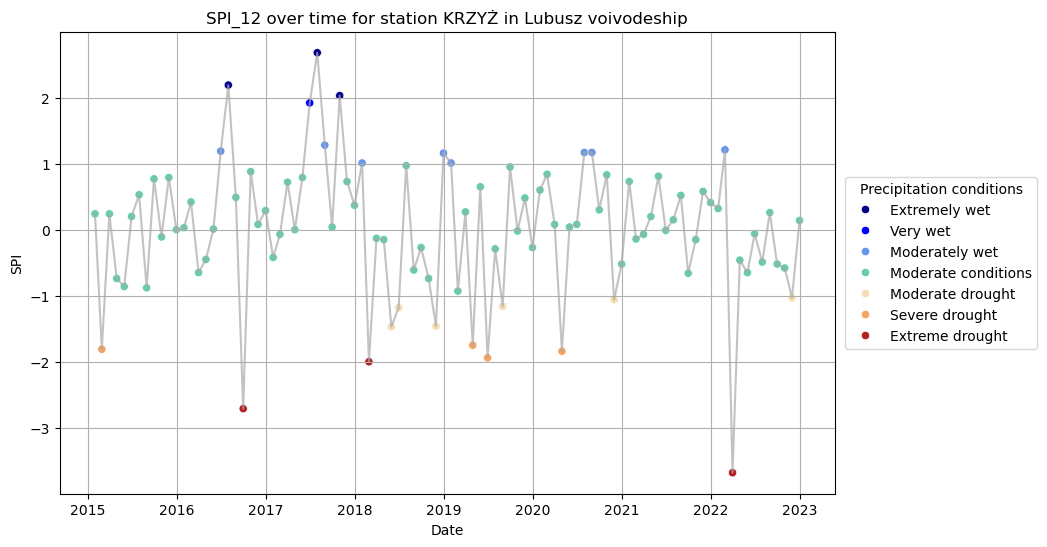

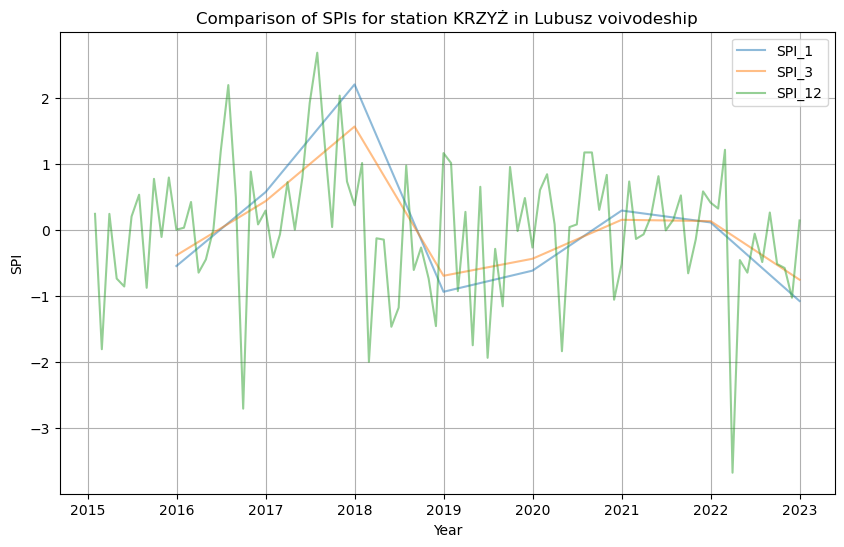

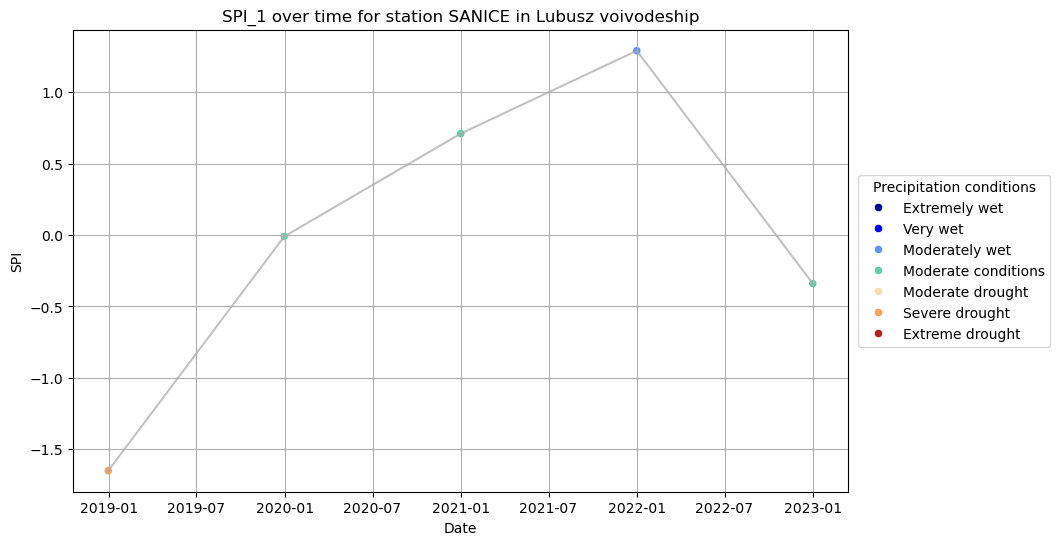

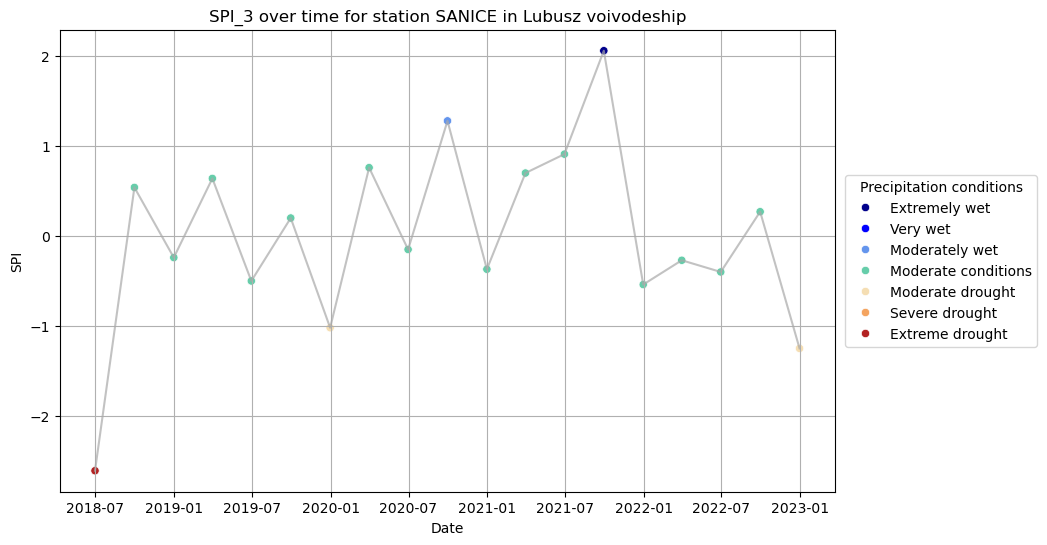

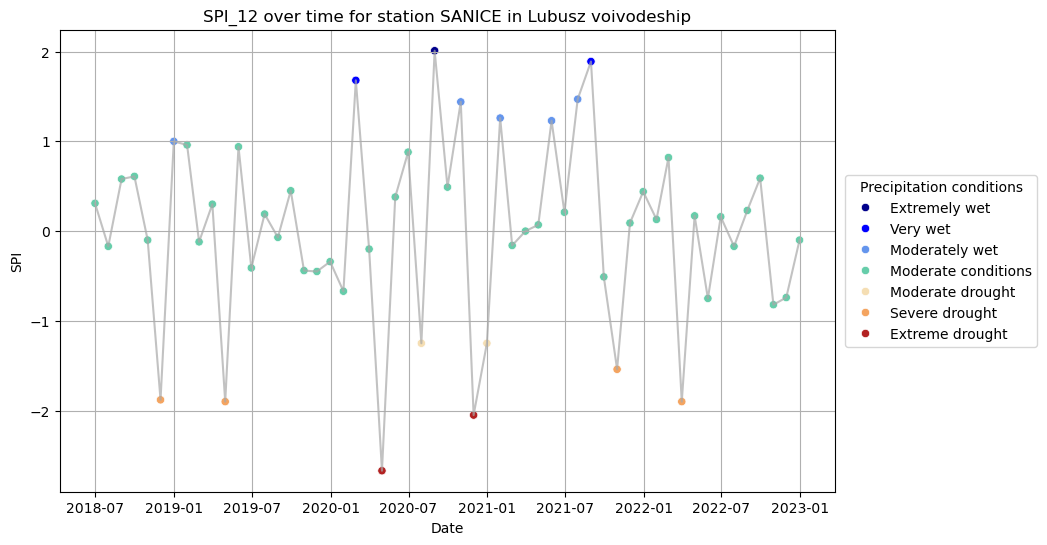

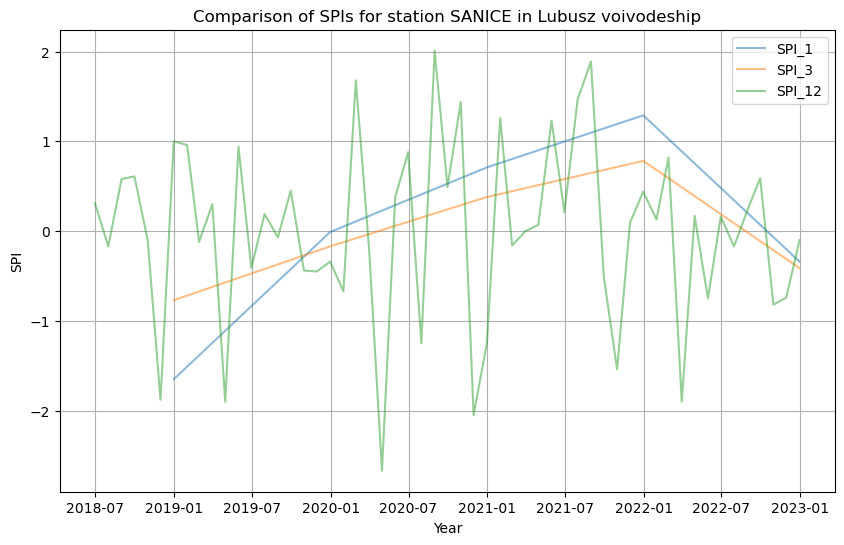

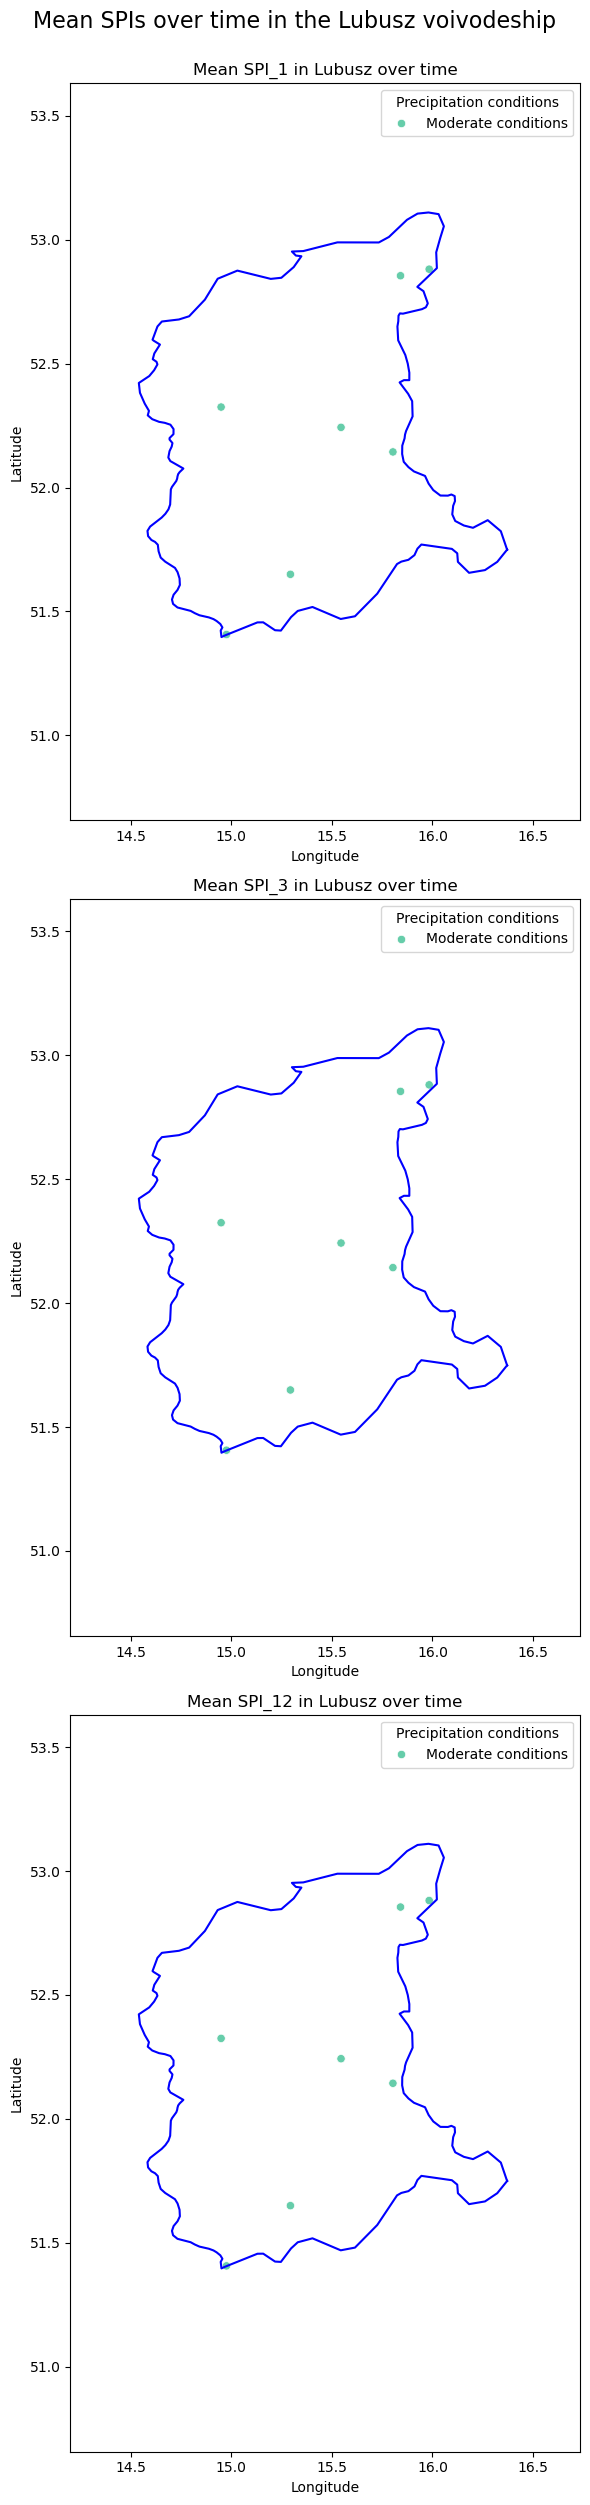

In [12]:
stations_SPI_pipeline(preprocessed_voi_df, voi_polygon, "Lubusz")

## SPI analysis for the voivodeship (Lubusz)

In [13]:
def get_voi_SPI_statistics(SPI_1, SPI_3, SPI_12, voi):
    save_df(
        pd.concat(
            [
                SPI_1.describe().rename(columns={"SPI": "Values"}),
                SPI_3.describe().rename(columns={"SPI": "Values"}),
                SPI_12.describe().rename(columns={"SPI": "Values"}),
            ],
            axis=1,
            keys=["SPI_1", "SPI_3", "SPI_12"],
        ),
        f"{voi}_SPI_statistics.csv",
        "../results",
    )
    print(
        f"Saved SPIs descriptive statistics from {voi} voivodeship in results/{voi}_SPI_statistics.csv"
    )

In [14]:
def visualize_voi_SPI(SPI_1, SPI_3, SPI_12, voi):
    SPI_1["State"] = SPI_1["SPI"].map(map_to_range)
    SPI_3["State"] = SPI_3["SPI"].map(map_to_range)
    SPI_12["State"] = SPI_12["SPI"].map(map_to_range)

    SPI_dict = {"SPI_1": SPI_1, "SPI_3": SPI_3, "SPI_12": SPI_12}

    color_palette = {
        "Extremely wet": "darkblue",
        "Very wet": "blue",
        "Moderately wet": "cornflowerblue",
        "Moderate conditions": "mediumaquamarine",
        "Moderate drought": "wheat",
        "Severe drought": "sandybrown",
        "Extreme drought": "firebrick",
    }

    hue_order = [
        "Extremely wet",
        "Very wet",
        "Moderately wet",
        "Moderate conditions",
        "Moderate drought",
        "Severe drought",
        "Extreme drought",
    ]


    fig, ax = plt.subplots(3, 1, figsize=(14, 17))

    n = 0


    for spi_key, spi_val in SPI_dict.items():
        sns.lineplot(
            spi_val, x=spi_val.index, y="SPI", color="darkgrey", alpha=0.7, ax=ax[n]
        )

        sns.scatterplot(
            spi_val,
            x=spi_val.index,
            y="SPI",
            hue="State",
            ax=ax[n],
            palette=color_palette,
            hue_order=hue_order,
        )

        ax[n].legend(
            title="Precipitation conditions",
            loc="right",
            bbox_to_anchor=(0.68, 0.25, 0.5, 0.5),
        )

        ax[n].set(
            title=f"{spi_key} in time for the {voi} voivodeship",
            xlabel="Date",
            ylabel="SPI",
        )

        ax[n].grid(True)

        n += 1


    plt.suptitle(f"SPIs over time for the {voi} voivodeship", y=1, fontsize=16)

    plt.tight_layout()

    plt.savefig(f"../results/SPI_in_time_{voi}.png", bbox_inches="tight")

    print(
        f"Figure with SPI over time for the {voi} voivodeship saved in results/SPI_in_time_{voi}.png"
    )

    # plt.show()

In [15]:
def voi_SPI_pipeline(preprocessed_voi_df, voi):
    if (
        (not os.path.exists(f"../results/{voi}_SPI_monthly.csv"))
        or (not os.path.exists(f"../results/{voi}_SPI_quarterly.csv"))
        or (not os.path.exists(f"../results/{voi}_SPI_yearly.csv"))
    ):
        SPI_1, SPI_3, SPI_12 = get_SPI(
            preprocessed_voi_df,
            voi,
            True,
        )
    else:
        SPI_1 = pd.read_csv(
            f"../results/{voi}_SPI_yearly.csv", index_col="date", parse_dates=True
        )
        SPI_3 = pd.read_csv(
            f"../results/{voi}_SPI_quarterly.csv", index_col="date", parse_dates=True
        )
        SPI_12 = pd.read_csv(
            f"../results/{voi}_SPI_monthly.csv", index_col="date", parse_dates=True
        )
    SPI_1["SPI"] = SPI_1["SPI"].round(2)
    SPI_3["SPI"] = SPI_3["SPI"].round(2)
    SPI_12["SPI"] = SPI_12["SPI"].round(2)
    get_voi_SPI_statistics(SPI_1, SPI_3, SPI_12, voi)
    visualize_voi_SPI(SPI_1, SPI_3, SPI_12, voi)

Lubusz_SPI_statistics.csv saved in ../results/
Saved SPIs descriptive statistics from Lubusz voivodeship in results/Lubusz_SPI_statistics.csv
Figure with SPI over time for the Lubusz voivodeship saved in results/SPI_in_time_Lubusz.png


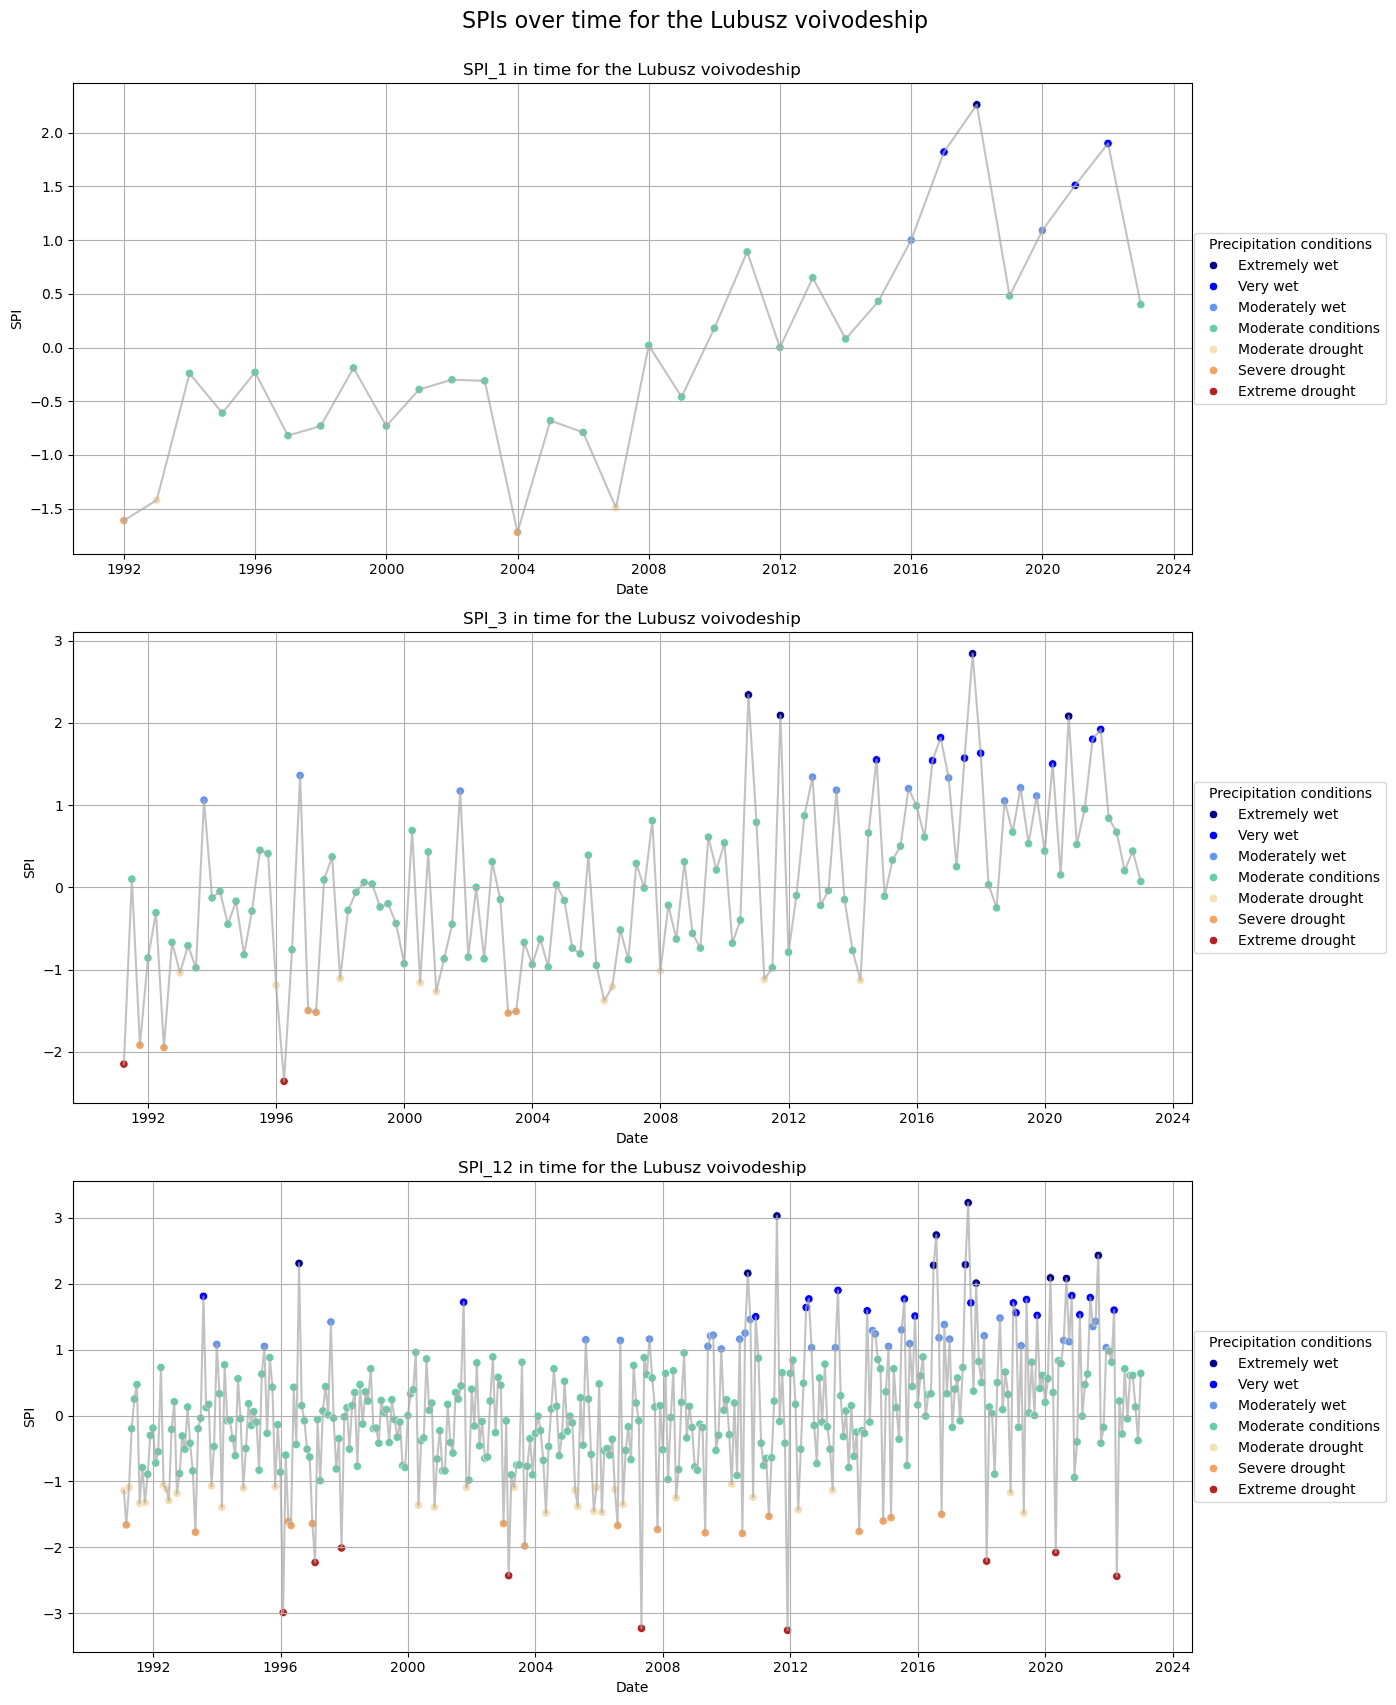

In [16]:
voi_SPI_pipeline(preprocessed_voi_df, "Lubusz")